<a href="https://colab.research.google.com/github/Marconiadsf/TechChallenger_2_Ibovespa/blob/main/Ibovespa_ETL%26FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv("Dados_Historicos_Ibovespa.csv", sep=",")
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.12.2025,160.766,159.189,161.263,159.189,"7,67B","0,99%"
1,11.12.2025,159.189,159.072,159.850,158.098,"7,02B","0,07%"
2,10.12.2025,159.075,157.984,159.691,157.628,"8,24B","0,69%"
3,09.12.2025,157.981,158.187,158.851,155.188,"8,70B","-0,13%"
4,08.12.2025,158.187,157.369,159.235,157.369,"9,02B","0,52%"


In [ ]:
df.shape

(523, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      523 non-null    object 
 1   Último    523 non-null    float64
 2   Abertura  523 non-null    float64
 3   Máxima    523 non-null    float64
 4   Mínima    523 non-null    float64
 5   Vol.      523 non-null    object 
 6   Var%      523 non-null    object 
dtypes: float64(4), object(3)
memory usage: 28.7+ KB


Base de dados 7 (?) features.

- Nescessário o tratamento de: Data, Vol., Var%
- Analisar amplitude das variáveis.  

In [ ]:
#Converter valores em Vol.

df.dtypes

def convert_volume(volume_str):
    if isinstance(volume_str, str):
        volume_str = volume_str.replace(',', '.').strip()
        if 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1_000_000_000
        elif 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1_000_000
        elif 'K' in volume_str:
            return float(volume_str.replace('K', '')) * 1_000
        else:
            return float(volume_str)
    return volume_str

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

In [ ]:
# Converter valores em Var%
df['Var%'] = df['Var%'].str.replace('%', '', regex=False)
df['Var%'] = df['Var%'].str.replace(',', '.', regex=False)
df['Var%'] = pd.to_numeric(df['Var%'], errors='coerce')
df['Var%'] = df['Var%'] / 100

In [ ]:
#Tratamento das informações de Data
df["Data"] = pd.to_datetime(df["Data"],format="%d.%m.%Y")
df = df.sort_values(by="Data", ascending=True)



In [ ]:
df.dtypes

,0
Data,datetime64[ns]
Último,float64
Abertura,float64
Máxima,float64
Mínima,float64
Vol.,float64
Var%,float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, 522 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      523 non-null    datetime64[ns]
 1   Último    523 non-null    float64       
 2   Abertura  523 non-null    float64       
 3   Máxima    523 non-null    float64       
 4   Mínima    523 non-null    float64       
 5   Vol.      523 non-null    float64       
 6   Var%      523 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 32.7 KB


Com os tratamentos básicos vamos verificar o comportamento do valor da Bovespa no intervalo analisado.

In [ ]:
#Importar pyplot para gráficos:
import matplotlib.pyplot as plt



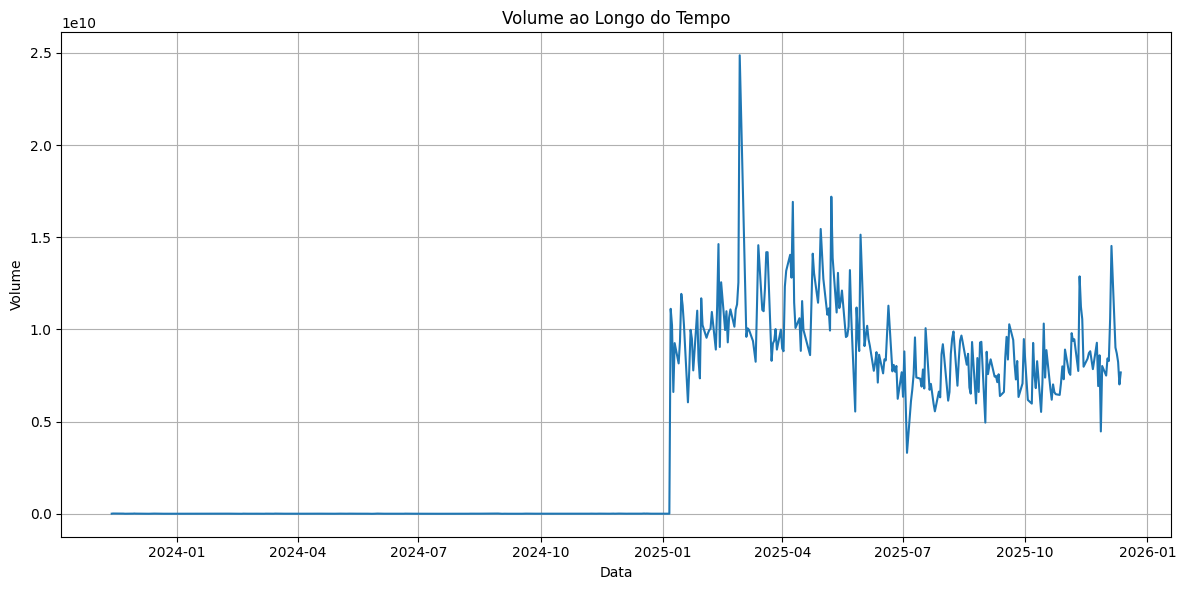

In [ ]:
# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df['Data'], df['Vol.'])
plt.title('Volume ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

Algo de errado na base? o que aconteceu para esta diferença?

In [ ]:
df['Vol.'].value_counts()

,count
Vol.,
9.370000e+06,6
6.610000e+09,4
9.070000e+06,3
9.800000e+06,3
1.053000e+07,3
...,...
1.132000e+07,1
8.620000e+06,1
9.810000e+06,1


In [ ]:
df['Vol.'].tail()

,Vol.
4,9.020000e+09
3,8.700000e+09
2,8.240000e+09
1,7.020000e+09
0,7.670000e+09


In [ ]:
df['Vol.'].head()

,Vol.
522,11200000.0
521,19430000.0
520,18360000.0
519,15720000.0
518,11110000.0


Hum... parece que pode ser realmente um salto no valor de negiciação em 2025 gerando uma diferença de escala. Vamos analisar essa coluna em especifico...


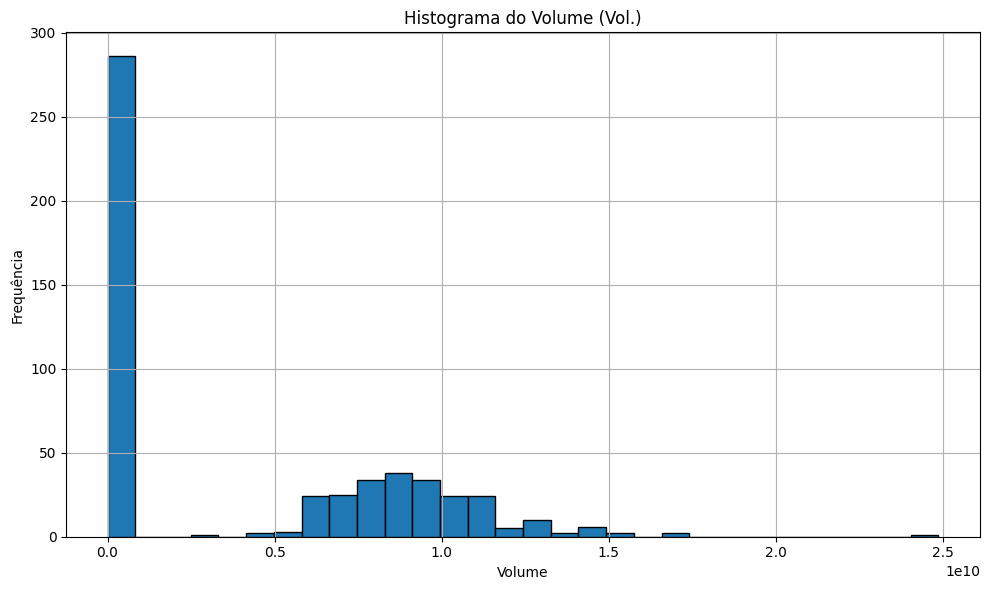

In [ ]:
# Gerar um histograma para a coluna 'Vol.'

plt.figure(figsize=(10, 6))
plt.hist(df['Vol.'], bins=30, edgecolor='black') # bins define o número de barras
plt.title('Histograma do Volume (Vol.)')
plt.xlabel('Volume')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

Dificil até de ver essa  freq. de distribuição, realmente os dados não parecem nada homogêneos. Tentando aplicar a raiz quadrada sobre os dados e plotar....

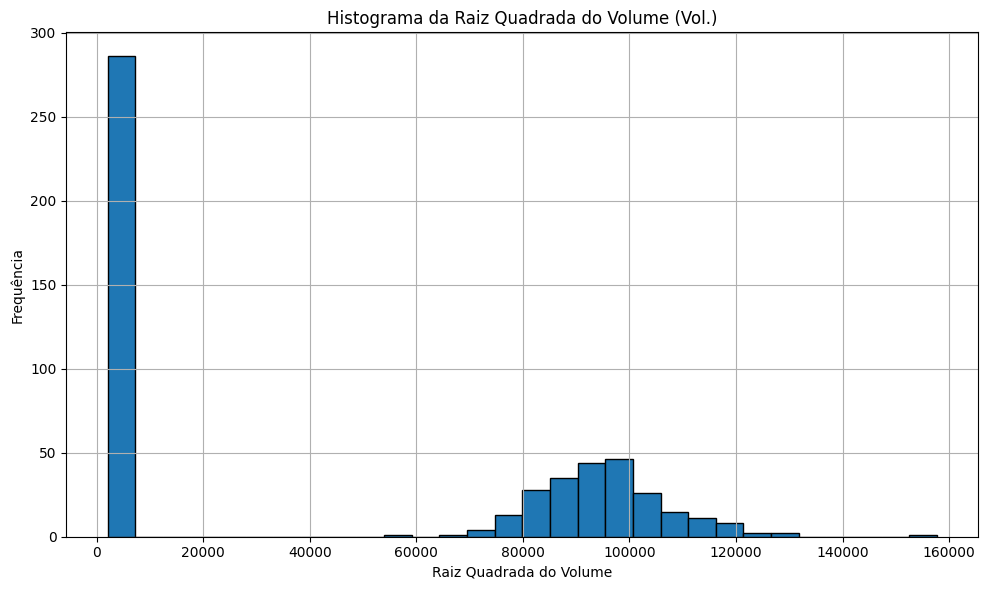

In [ ]:
import numpy as np


# Aplicar a raiz quadrada na coluna 'Vol.'
df['Vol._sqrt'] = np.sqrt(df['Vol.'])

# Gerar um histograma para a coluna transformada 'Vol._sqrt'
plt.figure(figsize=(10, 6))
plt.hist(df['Vol._sqrt'], bins=30, edgecolor='black') # bins define o número de barras
plt.title('Histograma da Raiz Quadrada do Volume (Vol.)')
plt.xlabel('Raiz Quadrada do Volume')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

Hum..continua complicado... olhando o boxplot...

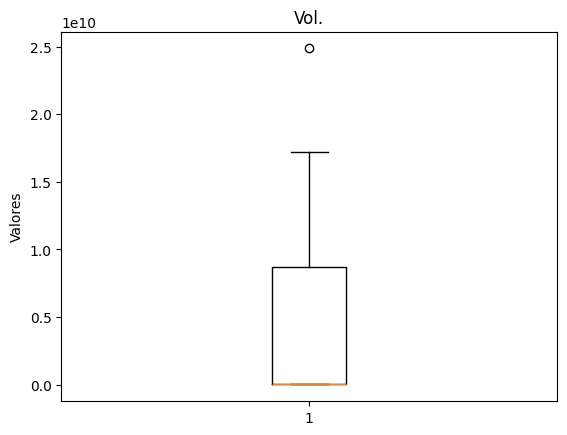

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Vol.'])
plt.title('Vol.')
plt.ylabel('Valores')
plt.show()

Investigar o por que da diferença entre 2024 e 2025 nos volumes negociados.
Olhar o boxplot das outras variáveis

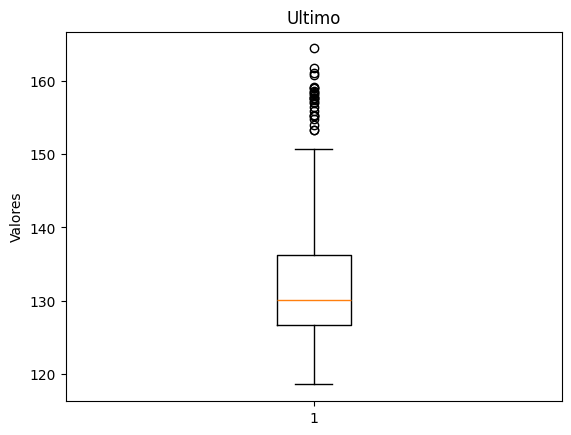

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Último'])
plt.title('Ultimo')
plt.ylabel('Valores')
plt.show()

In [ ]:
print(df['Último'].min())
print(df['Último'].max())

118.533
164.456


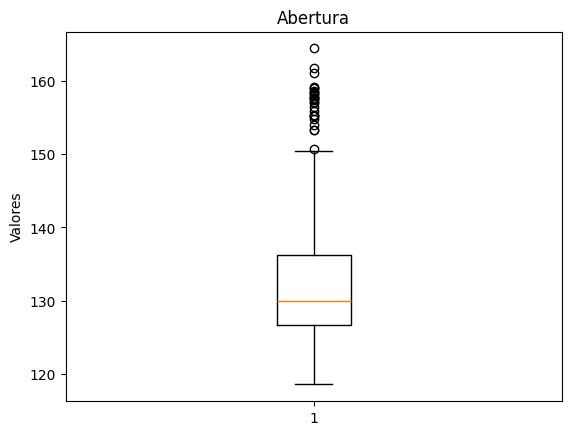

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Abertura'])
plt.title('Abertura')
plt.ylabel('Valores')
plt.show()

In [ ]:
print(df['Abertura'].min())
print(df['Abertura'].max())

118.534
164.461


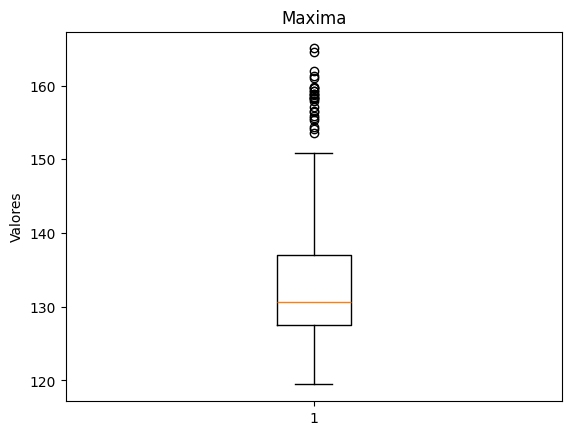

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Máxima'])
plt.title('Maxima')
plt.ylabel('Valores')
plt.show()

In [ ]:
print(df['Máxima'].min())
print(df['Máxima'].max())

119.451
165.036


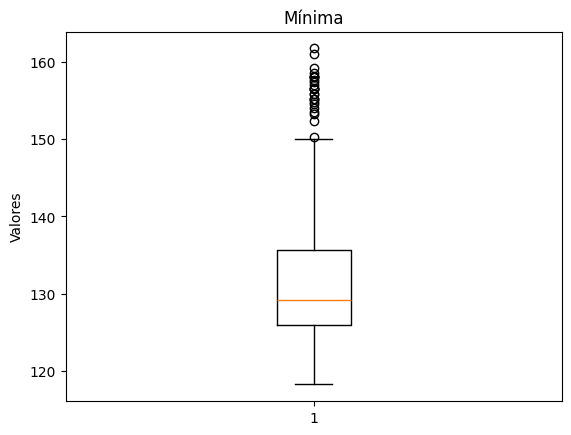

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Mínima'])
plt.title('Mínima')
plt.ylabel('Valores')
plt.show()

In [ ]:
print(df['Mínima'].min())
print(df['Mínima'].max())

118.223
161.759


In [ ]:
print(df['Vol.'].min())
print(df['Vol.'].max())

4330000.0
24870000000.0


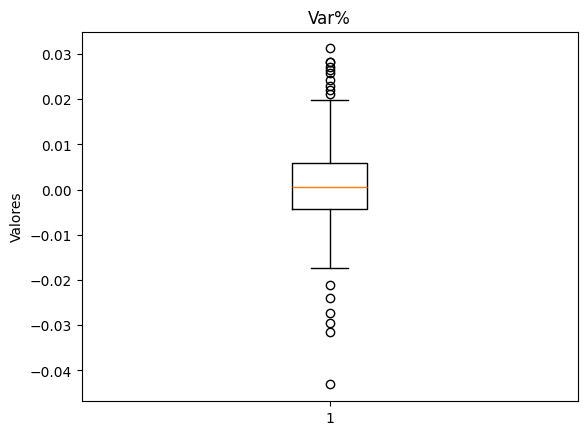

In [ ]:
# Criar o gráfico de boxplot
plt.boxplot(df['Var%'])
plt.title('Var%')
plt.ylabel('Valores')
plt.show()

In [ ]:
print(df['Var%'].min())
print(df['Var%'].max())

-0.0431
0.031200000000000002


Conclusão (Responder):
- As escalas são diferentes?
- Alguma categoria precisa de transformação?
- Quais features precisam ser criadas/alteradas ?
  - R: Criar:
    - Tendencia
    - Var. Diária
    - Médias móveis (geralmente usado em análise de graficos de candle para uma ação qualquer na bolsa, cryptos e outros ativos financeiros - definir quantas e quais intervalos)

In [ ]:
#Criando a coluna tendência

df['Tendencia'] = np.select(
    [df['Var%'] > 0, df['Var%'] < 0],
    ['Alta', 'Baixa'],
    default='Estável' # Assuming 0 can be 'Estável' or handle as needed
)
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Tendencia
0,12.12.2025,160.766,159.189,161.263,159.189,7.670000e+09,0.0099,Alta
1,11.12.2025,159.189,159.072,159.850,158.098,7.020000e+09,0.0007,Alta
2,10.12.2025,159.075,157.984,159.691,157.628,8.240000e+09,0.0069,Alta
3,09.12.2025,157.981,158.187,158.851,155.188,8.700000e+09,-0.0013,Baixa
4,08.12.2025,158.187,157.369,159.235,157.369,9.020000e+09,0.0052,Alta


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustar e transformar os rótulos
df['Tendencia'] = label_encoder.fit_transform(df['Tendencia'])

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Tendencia,rData
509,1673481600,128.185,127.331,128.185,126.656,13700000.0,0.0067,0,2023-01-12
508,1681257600,126.803,128.183,128.183,126.643,10270000.0,-0.0108,1,2023-04-12
507,1683849600,126.903,126.802,127.489,126.491,11960000.0,0.0008,0,2023-05-12
506,1686528000,125.623,126.907,127.538,125.614,10840000.0,-0.0101,1,2023-06-12
505,1689120000,126.010,125.623,126.581,125.566,10510000.0,0.0031,0,2023-07-12



#Daqui por diante são o passo a passo do notebook de Aula sobre regressões, não foi revisado/adaptado.
______________

OK, como próximo passo, antes de normalizar ou padronizar, vamos separar os dados em treino e teste:

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Tendencia','Var%', 'rData']) # Variáveis características
y = df['Tendencia'] # O que eu quero prever. (Target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Quanto a esses detalhes de separação de dados em treino e teste, não se preocupe que em Machine Learning avançado você irá aprender cada passo! 😄

Vamos escalonar os dados? Importamos os escalonadores da biblioteca **sklearn** em **preprocessing** o **StandardScaler** e **MinMaxScaler**:

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Aplicando MinMax Scaler**

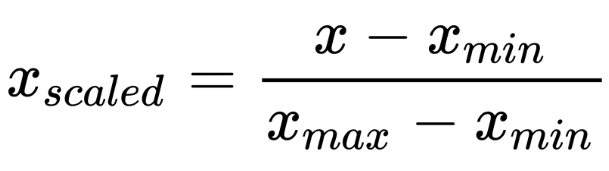

O escalonamento min-max (normalização) é muito simples! Basicamente os valores são deslocados e redimensionados para que acabem variando de 0 a 1. Observe a fórmula a seguir, esse cálculo subtrai o valor mínimo e divide pelo máximo, menos o mínimo.


In [ ]:
scaler = MinMaxScaler() #chamando o metodo de normalização dos dados (0-1)

scaler.fit(X_train)

x_train_min_max_scaled = scaler.transform(X_train)
x_test_min_max_scaled= scaler.transform(X_test)

In [ ]:
x_train_min_max_scaled

array([[0.00000000e+00, 7.24650808e-01, 7.43819948e-01, 7.21921936e-01,
        7.45764781e-01, 3.58151218e-01],
       [9.96108062e-01, 2.31658483e-01, 2.03222236e-01, 2.32636564e-01,
        2.09271103e-01, 1.52821139e-04],
       [0.00000000e+00, 1.55646661e-01, 1.49477309e-01, 1.57969004e-01,
        1.39701216e-01, 4.85408195e-04],
       ...,
       [0.00000000e+00, 3.91547886e-01, 4.17685402e-01, 3.90820817e-01,
        4.09925304e-01, 2.73295270e-01],
       [0.00000000e+00, 1.02493207e-02, 3.44853032e-02, 1.84396824e-02,
        2.31411414e-02, 1.69309735e-04],
       [9.97059425e-01, 2.03317920e-01, 1.86692904e-01, 2.05395580e-01,
        1.92794024e-01, 2.07112859e-04]])

Mas você deve estar se perguntando:

*“por que é realizado o escalonamento (fit) na base treino e não na base de teste?”.*

Bem, realizamos a transformação do escalonamento na base de treino para **evitar que a base de teste fique exatamente igual às estatísticas da base de treino**, o que evita **“vazamento”** desses dados. A base de teste em geral deve representar uma base de dados nunca vista antes pelo algoritmo, justamente para testar se o algoritmo consegue generalizar os dados.


Agora vamos testar com **StandarScaler**.

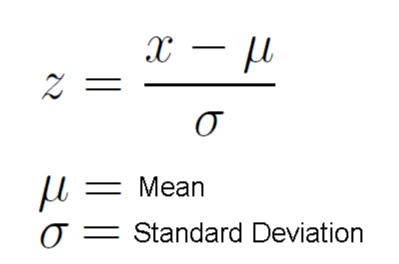

A padronização não vincula valores específicos nos mínimos e máximos, o que pode ser um ponto de atenção em alguns algoritmos (por exemplo, redes neurais). No entanto, a padronização é muito menos afetada por outliers.  Na biblioteca do Scikit-Learn temos a padronização em StandardScaler.




In [ ]:
scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

scaler.fit(X_train)# qual média e std será utilizado para o escalonamento

x_train_standard_scaled = scaler.transform(X_train)
x_test_standard_scaled  = scaler.transform(X_test)

In [ ]:
x_train_standard_scaled

array([[-0.79950749,  1.99561278,  1.94618433,  1.92670344,  2.02499424,
         0.93920679],
       [ 1.2484889 , -0.42501703, -0.66792884, -0.47991771, -0.57960976,
        -0.88645161],
       [-0.79950749, -0.79824086, -0.9278177 , -0.84718094, -0.91736212,
        -0.88475554],
       ...,
       [-0.79950749,  0.3600521 ,  0.36912879,  0.29813451,  0.39453916,
         0.50647308],
       [-0.79950749, -1.51215286, -1.4838728 , -1.53347617, -1.48324547,
        -0.88636752],
       [ 1.2504449 , -0.56417135, -0.74785805, -0.61390644, -0.65960374,
        -0.88617474]])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Vamos testar o algoritmo sem os escalonadores e validar os resultados!

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.53


Testando com a normalização:

In [ ]:
model_min_max = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model_min_max.fit(x_train_min_max_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred_min_max = model.predict(x_test_min_max_scaled)

accuracy_min_max = accuracy_score(y_test, y_pred_min_max)
print(f'Acurácia: {accuracy_min_max:.2f}')

Acurácia: 0.47


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Testando com a padronização

In [ ]:
model_standard = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model_standard.fit(x_train_standard_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred_standard = model.predict(x_test_standard_scaled)

accuracy_strandard = accuracy_score(y_test, y_pred_standard)
print(f'Acurácia: {accuracy_strandard:.2f}')

Acurácia: 0.47


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Uau! Os escalonadores realmente mudam  o resultado de alguns algoritmos! Nessa aula aprendemos a importância dos escalonadores. Que tal você testar em com mais tipos de algoritmos?